In [1]:
def hide_toggle_code(off=0):
    """This function generates HTML code to toggle the display of an input cell.
    
    The output of the cell will still be displayed.  This can be used to hide 
    (from immediate view) some code to generate data or the like.  It can also 
    be used to hide other notebook explicit implementations - e.g., C++ processing,
    or the like.
    
    Note, calling this function alone will not enable toggling.  Instead, we must wrap 
    the generated code in an `IPython.display.HTML` object and return that as the 
    cell value.  This will let IPython evaluate the HTML code and pass it on to
    the browser. 
    
    If all one wants is to toggle a cell one can use the function `hide_toggle` below. 
    However, we can also combine the code generated here with other HTML code - for 
    example _style_ declarations and pass that along embedded in an HTML object. 
    
    Parameters
    ----------
    off : int 
        Offset of cell to hide relative to the cell calling this function 
    
    Returns
    -------
    code : str 
        HTML code to enable toggling of the cell 
    """
    import random

    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'
    prev_cell = this_cell + '.prev()'

    toggle_text = 'Please close'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if off > 0:
        target_cell = next_cell
        js_hide_current = this_cell + '.find("div.input").hide();'
    elif off < 0:
        target_cell = prev_cell
        js_hide_current = this_cell + '.find("div.input").hide();'
        
    rand      = str(random.randint(1,2**64))
    js_f_name = 'code_toggle_{}'.format(rand)

    html = """
        <script id=s{rand}>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
                {cell_selector}.find('div.out_prompt_overlay.prompt').toggle();
                {cell_selector}.find('div.out_prompt_overlay.prompt').toggle();
                {cell_selector}.find('div.prompt.output_prompt').toggle();
            }}
            // console.log('Loading cell with hide_toggle')
            {js_hide_current}
        </script>

        <details style='z-index:99,position:relative;color:lightgray' 
                 ontoggle='javascript:{f_name}()'>
          <summary></summary>
          {toggle_text}
        </details>
        <script>
          var p = $('#s{rand}').parents();
          p.siblings('div.input').hide();
          p.find('div.prompt.output_prompt').hide()
          p.find('div.out_prompt_overlay.prompt').hide()
        </script>    
    """.format(
        rand = rand,
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return html

def hide_toggle(off=0,cnt=None):
    """This will wrap the HTML code returned from the above function
    in an `IPython.display.HTML` object so that the notebook will 
    evaluate the HTML code. 
    
    This function is what we will use most of the time.  However, 
    the function `hide_toggle_code` can be combined with other code 
    and then be put  into an HTML object to let the notebook evaluate
    all the code. 

    Parameters 
    ----------
    off : int 
        Cell offset relative to calling cell which we should toggle 
    cnt : int or None 
        If not None, set the execution count to this number 
        (currently broken)
        
    Returns
    -------
    object : IPython.display.HTML 
        HTML object wrapping code to toggle cell 
    """
    from IPython.display import HTML
    if cnt is not None:
        get_ipython().execution_count = cnt
    return HTML(hide_toggle_code(off))
# hide_toggle(cnt=0)


def _setup_matplotlib():
    """Set-up Matplotlib parameters. 
    
    We specify that we want both PDF and PNG images, and 
    that the default image size should be 8 by 8 inches 
    
    We also disable warnings about too many open figures 
    """
    %matplotlib inline 
    from matplotlib import rcParams 
    
    rcParams['figure.max_open_warning'] = 0
    rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
    rcParams['font.family'] = ['serif']
    rcParams['mathtext.fontset'] = 'dejavuserif'
    rcParams['axes.formatter.use_mathtext'] = True
    
    try:
        from IPython.display import set_matplotlib_formats
        set_matplotlib_formats('png','pdf')
    except Exception as e:
        pass 
    
_setup_matplotlib()

def css_styling():
    """This function returns HTML code to customize the CSS 
    of the notebook 
    
    - The text font to be Palatino (serif)
    - Headers are oblique (italic)
    - Extra spacing below H1 headers 
    - Extra spacing spacing above H1 headers 
    - Headers have larger fonts, and is set in normal weight
    - Remove padding around code cells 
    - Code uses the fint "Source Code Pro" (or monospace)
    - Code background is changed to light yellow 
    - Output background is set to lavender
    
    The function combines these CSS declarations with the HTML 
    code from `hide_toggle_code` above so what we automatically 
    hide this code from the user. 
    """
    from IPython.core.display import HTML

    try:
        styles = """
        <style>
        .rendered_html {
            font-family: Palatino, serif
        }
        h1, h2, h3, h4 {
            font-style: oblique;  
        }
        .rendered_html h1:first-child {
            margin-top: 4ex;
        }
        .rendered_html h1 {
            margin-bottom: 2ex;
            font-weight: normal;
            font-size: 220%;
        }
        .rendered_html h2 {
            font-weight: normal;
            font-size: 180%;
        }
        .rendered_html h3 {
            font-weight: normal
        }
        .rendered_html h4 {
            font-weight: normal
        }
        .rendered_html p code {
            padding: 0;
        }
        .CodeMirror, code, div.input_area {
            font-family: "Source Code Pro", source-code-pro,Consolas, monospace;
            background: lightyellow;
        }
        .output_text, .output_stream, .output_stdout {
            background: lavender;
        }
        </style>
        """
        return HTML(hide_toggle_code() + styles)
    except Exception as e:
        print('Failed to set CSS style',e)
        pass
    return None
css_styling()

In [2]:
import IPython.core.magic as ipym

@ipym.magics_class
class CppMagic(ipym.Magics):
    """Register cell and line magic to deal with C++ code"""
    def __init__(self, shell=None,  **kwargs):
        """Constructor.  Here we simply set up an argument parser"""
        super(CppMagic, self).__init__(shell=shell, **kwargs)
        
        from argparse import ArgumentParser, REMAINDER
        
        self._parser = ArgumentParser('C++ magic line parser')
        self._parser.add_argument('filename',
                                  help='Filename to store in')
        self._parser.add_argument('-m','--mode',choices=['return','print','eval'],
                                  default='return',
                                  help='What to do with the output of the program')
        self._parser.add_argument('args',nargs=REMAINDER)
        
    def _compile(self, filename):
        """Compile a file into code
        
        Parameters
        ----------
            filename : string 
                the file to compile 
                
        Throws
        ------
        e : CalledProcessError 
            In case of trouble compling file 
        """
        from subprocess import run 
        
        run(["g++", "-O3", filename, "-o", filename + ".out"], 
            check=True,capture_output=True)

    def _run(self, filename,*args):
        """Run a previously compiled program 
        
        Parameters
        ----------
            filename : str 
                Base name of file to execute
            args : other 
                Aditional arguments for program
                
        Returns
        -------
        output : str 
            Output of command 
            
        Raise
        -----
        
        e : CalledProcessError 
            In case of trouble executing code  
        """
        from subprocess import run 
        
        cmd = ["./" + filename + ".out",*args]
        ret = run(cmd, check=True, capture_output=True)
        
        output = ret.stdout.decode('utf8')
        return output
    
    def _write(self,filename,cell):
        """Write a file 
        
        Parameters
        ------------
        - filename : str 
                file to write to 
        
        """
        with open(filename,'w') as file:
            file.write(cell)
       
    @ipym.cell_magic
    def cppfile(self,line,cell):
        """Write named file to disk 
        
        Parameters
        -----------
            line : str Magic line 
            cell : Cell content
            """
        filename = line.strip()
        if filename == '':
            print('No filename passed to %%cppfile magic')
            return None
        
        self._write(filename, cell)
        
    @ipym.cell_magic
    def cpp(self, line, cell):
        """Write, compile. and execute code 
        
        Parameters 
        -----------
            line : %magic line 
            cell : Content
        """
        from sys import stderr
        from subprocess import CalledProcessError
        
        try:
            args = self._parser.parse_args(line.split())
        except SystemExit as e:
            self._parser.print_help()
            return

        self._write(args.filename, cell)
        
        try:
            self._compile(args.filename)
            output = self._run(args.filename,*args.args)
            
            if args.mode in ['print', 'eval']:
                print(output)
                
                if args.mode == 'eval':
                    get_ipython().ex(output)
                
                output = None
                
        except CalledProcessError as e:
            if e.stderr is not None:
                print(e.stderr.decode('utf8'),file=stderr)
            else:
                print(e.stdout.decode("utf8"))
            output = None
                   
        return output
    
## use ipython load_ext mechanisme here if distributed
get_ipython().register_magics(CppMagic)
    
def CppStyle():
    from IPython.display import HTML
    code =  """
        <script>
        /* require(['notebook/js/codecell'], function(codecell) {
            console.log('Register %%cpp magic with CodeMirror')
             codecell.CodeCell.options_default.highlight_modes['magic_text/x-c++'] = 
                 {'reg':[/^%%cpp/,/^%%cppfile/]} ;
             Jupyter.notebook.events.one('kernel_ready.Kernel', function(){
                 Jupyter.notebook.get_cells().map(function(cell){
                     if (cell.cell_type == 'code'){ cell.auto_highlight(); } }) ;
            });
        }); */
        IPython.CodeCell.options_default.highlight_modes['magic_text/x-c++src'] = 
            {'reg':['^%%cpp','^%%cppfile']} ;
        IPython.notebook.events.one('kernel_ready.Kernel', function(){
            IPython.notebook.get_cells().map(function(cell){
                if (cell.cell_type == 'code'){ cell.auto_highlight(); } }) ;
        });
        </script>"""
    return HTML(hide_toggle_code()+code)

CppStyle()

# Comparison of correlator algorithms

# Algorithms 

Both algorithms below calculate the m-particle correlator

$$C_{\mathbf{h}}\{m\}(Q)\quad,$$

using recursion. Above, $m$ is the number of elements in $\mathbf{h}$, and $\mathbf{h}$ is a vector of integer harmonics.

## First, a debug tool

In [3]:
class Dbg:
    """Debug guard"""
    _indent = ''
    
    def __init__(self,*args):
        self._args = args
        
    @classmethod
    def _incr(cls):
        cls._indent += ' '
        
    @classmethod
    def _decr(cls):
        cls._indent = cls._indent[:-1]
        
    @classmethod
    def _ind(cls,mark):
        print(f'{cls._indent}{mark} ', end='')
        
    @classmethod 
    def _msg(cls,*args,mark=''):
        cls._ind(mark)
        print(*args)
        
    def __enter__(self):
        Dbg._msg('=>',*self._args)
        Dbg._incr()
        return self 
        
    def __exit__(self,exception_type, exception_value, traceback):
        Dbg._decr()
        Dbg._msg('<=',*self._args)
        
    def msg(self,*args,mark='=='):
        Dbg._msg(mark,*args)

## Algorithm from Kris

This is an implementation of Kris’ algorithm in Python. Note, we utilize views of lists to simplify
the algorithm a lot. It should also make it more effective. This algorithm does not copy data
around too much, which makes it effective.

In [4]:
def correlator1(q,harmonics,skip=None,mult=1):
    r"""Calculates the :math:`m` particle correlator from the
    :math:`Q`-vector `q`

    .. math:

        C_{\mathbf{h}}\{m\}(Q)

    where :math:`m` is the number of elements in :math:`\mathbf{h}`.

    Parameters
    ----------
    q : QVector
        The :math:`Q`-vector
    harmonic : list of harmonics (int)
        The harmonic vector :math:`\mathbf{h}`
    skip : int
        The last harmonic to consider.
        This is the offset from the end of the harmonic vector.
        This means that `skip` is negative. Initially this must
        be set to `None`. The value will be overriden in rescursive
        calls to this function.
    mult : int
        Number of particles correlated.
        Initially this must be to 1

    Returns
    -------
    C : complex
        The correlator value
    """
    # Pop last
    head = harmonics[-1]
    tail = harmonics[:-1]
    c    = q(head,mult)
    n    = len(tail)

    # If no more, return
    if n == 0:
        return c

    # Calculate on the rest
    z2 =  correlator1(q,tail)
    c  *= z2

    # If no skip given, then we start from first harmonic
    if skip is None:
        skip = -len(harmonics)

    # if end points last, return
    if skip == 0:
        return c


    last  = -1
    front = 0
    back  = last
    c2    = 0

    while back > skip:
        # Store front, set front to last, set last to front + popped
        h_hold, tail[front], tail[last] = tail[front], tail[last], tail[front]+head

        # Calculate on rearranged rest
        c2 += correlator1(q,tail,back,mult+1)

        # Swap back
        tail[front],tail[last] = h_hold,tail[front]
        back -= 1
        front += 1

    return c - mult * c2

## Algorithm from Vytautas

This algorithm is a port of Vytautas’ algorithm. We have an explicitly specialisation for 2-particle
correlators which will help in terms of execution speed. On the other hand, Vytautas’ original C++
code passes arguments by value and copies things around which makes it less efficient.

In [5]:
def two(q,h1,h2,p1,p2):
    """Calculate the two-particle correlator from a :math:`Q`-vector
    This calculates
    
    .. math:
    
        C_{h_1,h_2}\{2\} = Q_{h_1,p_1}Q_{h_2,p_2} - Q_{h_1+h_2,p_1+p_2}
    
    Parameters
    ----------
    q : QVector
        The :math:`Q`-vector
    h1 : int
        :math:`h_1`
    h2 : int
        :math:`h_2`
    p1 : int
        :math:`p_1`
    p2 : int
        :math:`p_2`
        
    Returns
    -------
    C2 : complex
        The two-particle correlator :math:`C_{h_1,h_2}\{2\}`
    """
    return q(h1,p1)*q(h2,p2)-q(h1+h2,p1+p2)

In [6]:
def correlator2(q,hars,pows=None):
    r"""Calculates the :math:`m` particle correlator from the
    :math:`Q`-vector `q`

    .. math:
        
        C_{\mathbf{h}}\{m\}(Q)
        
    where :math:`m` is the number of elements in :math:`\mathbf{h}`.

    Parameters
    ----------
    q : QVector
        The :math:`Q`-vector
    harmonic : list of harmonics (int)
        The harmonic vector :math:`\mathbf{h}`
    pows : list of powers (int)
        The list of powers for each harmonic considered. Initially
        this must be `None`. In recursive calls this is overwritten

    Returns
    -------
    C : complex
        The correlator value
    """
    hars = hars.copy() # Passed by value!
    
    if pows is None:
        pows = []
    else:
        pows = pows.copy() # Passed by value!
        
    if len(pows) < len(hars):
        pows = [1]*len(hars)
    
    c = q(hars[-1],pows[-1])
    if len(hars) < 2: return c
    if len(hars) < 3: return two(q,*hars, *pows)
    
    harlast = hars.pop() # Get last elements and
    powlast = pows.pop() # remove them
    
    
    formula = correlator2(q,hars,pows) * c
    
    for i in range(len(hars)):
        lhars    =  hars.copy() # Explicit copy!
        lpows    =  pows.copy() # Explicit copy!
        lhars[i] += harlast
        lpows[i] += powlast
        formula  -= correlator2(q,lhars,lpows)
    
    return formula

# Symbolic testing of the two algorithms

First, we import _SymPy_ because we want to check the expression generated by the two algorithms.
We declare the variable `Q` (our $Q$-vector) as function, and the variable `h` as indexable (or harmonic
vector $\mathbf{h}$).

In [7]:
from sympy import Function, symbols, IndexedBase, init_printing, S
init_printing()

Q = Function('Q',complex=True)
h = IndexedBase('h')

We make a function to help us set-up a harmonic vector $\mathbf{h}$.

In [8]:
def makeHV(m):
    """Make a harmonic vector of size $m$"""
    return [h[i+1] for i in range(m)]

Let us define a simple function that will test two expression for equality

In [9]:
hv = makeHV(4)
c1 = correlator1(Q,hv)
c1 

In [10]:
c2 = Q(h[3],1) * (Q(h[2],1) * Q(h[1],1) - 1 * (0 + Q(h[1] + h[2],2))) - 1 * (0 + Q(h[1] + h[3],2) * Q(h[2],1) - 2 * 0 + Q(h[2] + h[3],2) * Q(h[1],1) - 2 * (0 + Q(h[1] + h[2] + h[3],3)))
c2 = Q(h[4],1) * (Q(h[3],1) * (Q(h[2],1) * Q(h[1],1) - 1 * (0 + Q(h[1] + h[2],2))) - 1 * (0 + Q(h[1] + h[3],2) * Q(h[2],1) - 2 * 0 + Q(h[2] + h[3],2) * Q(h[1],1) - 2 * (0 + Q(h[1] + h[2] + h[3],3)))) - 1 * (0 + Q(h[1] + h[4],2) * (Q(h[2],1) * Q(h[3],1) - 1 * (0 + Q(h[3] + h[2],2))) - 2 * 0 + Q(h[2] + h[4],2) * (Q(h[3],1) * Q(h[1],1) - 1 * (0 + Q(h[1] + h[3],2))) - 2 * (0 + Q(h[1] + h[2] + h[4],3) * Q(h[3],1) - 3 * 0) + Q(h[3] + h[4],2) * (Q(h[2],1) * Q(h[1],1) - 1 * (0 + Q(h[1] + h[2],2))) - 2 * (0 + Q(h[1] + h[3] + h[4],3) * Q(h[2],1) - 3 * 0 + Q(h[2] + h[3] + h[4],3) * Q(h[1],1) - 3 * (0 + Q(h[1] + h[2] + h[3] + h[4],4))))

In [11]:
c1.expand()

In [12]:
c2.expand()

In [13]:
c1-c2

In [14]:
def compare(e1,e2,n1,n2):
    """compare expression e1 with e2 and print if there's a problem"""
    from sympy import latex
    from IPython.display import Latex
    
    d = (e1-e2)
    c = d.expand()
    
    if c != S.Zero:
        print(f'{n1} and {n2} are not equal')
        display(Latex('$$'+latex(e1)+r'\ne '+latex(e2)+'$$'))
        display(Latex(r'$$\Delta='+latex(d)+"$$"))
        return False
    
    return True

More so, we make one function that calls both algorithms above for the same harmonic vector and
then compares the results

In [15]:
def compAlgo(m):
    hv = makeHV(m)
    C1 = correlator1(Q,hv)
    C2 = correlator2(Q,hv)
    return compare(C1,C2,f"K{m}",f"V{m}")

Let us run the test

In [16]:
for m in range(2,6):
    compAlgo(m)

We see no warnings, so the algorithms give the same result.

## Timing tests
We will run as simple timing test on the two algorithms. We calculate the 5-particle correlator for
both a number of times to get the timing.

In [17]:
hv = makeHV(5)

In [18]:
%timeit correlator1(Q,hv)

2.65 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%timeit correlator2(Q,hv)

5.25 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We see that the first algorithm is slightly faster than the second - at least in the Python implementation.

Let us do a bit more. We vary $m$ and run the calculations $N$ times for each $m$. We then calculate
the mean time and uncertainty and return the results.

In [20]:
def timeTwo(n,maxM):
    from timeit import default_timer as timer
    from numpy import mean, std, sqrt
    
    def timeOne(Q,hv,algorithm):
        start = timer()
        algorithm(Q,hv)
        return timer()-start
    
    ms = list(range(2,maxM+1))
    m1 = []
    m2 = []
    u1 = []
    u2 = []
    for m in ms:
        hv = makeHV(m)
        ts1 = [timeOne(Q,hv,correlator1) for _ in range(n)]
        ts2 = [timeOne(Q,hv,correlator2) for _ in range(n)]
        m1.append(mean(ts1))
        m2.append(mean(ts2))
        u1.append(std(ts1,ddof=1)/sqrt(n))
        u2.append(std(ts2,ddof=1)/sqrt(n))
    
    return ms,m1,u1,m2,u2

To make life easier, we also define a plotting function

In [21]:
def plotTime(ms,m1,u1,m2,u2,ax=None):
    from matplotlib.pyplot import gca
    
    if ax is None:
        ax = gca()
    
    ax.errorbar(ms,m1,u1,fmt='o',color='C1',label='Algorithm 1')
    ax.errorbar(ms,m2,u2,fmt='s',color='C2',label='Algorithm 2')
    ax.legend()
    ax.set_xlabel('$m$')
    ax.set_ylabel('$t$')
    ax.set_yscale('log')

Let us run our test and plot the result

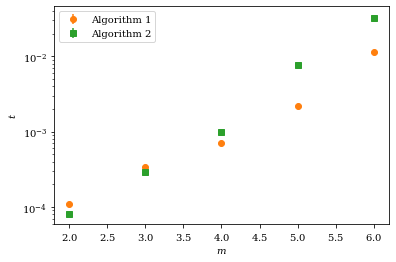

In [22]:
res = timeTwo(100,6)
plotTime(*res)

Equivalent C++ implementations are also timed.

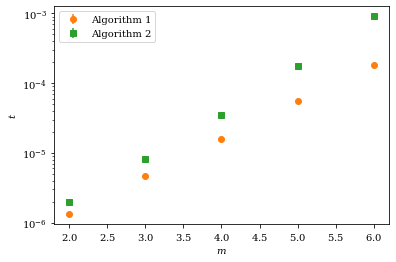

In [23]:
ms = [2,3,4,5,6]
m1 = [1.33703e-06,4.60566e-06,1.5649e-05,5.48356e-05,0.00017916]
u1 = [1.15263e-13,4.95538e-14,3.42296e-13,1.28947e-11,6.92466e-12]
m2 = [1.9963e-06,8.19168e-06,3.4684e-05,0.000175842,0.000909024]
u2 = [9.30164e-15,8.40328e-14,2.67115e-13,3.62006e-11,1.18975e-10]
plotTime(ms,m1,u1,m2,u2)

# Comparison to closed form expression

Below, we write up the closed form expression. These are extracted by the program `symbolic` from
the [m-correlations reference implementation](https://gitlab.cern.ch/cholm/mcorrelations).

Note, the output assumes the $Q$-vector is called `r`, so we alias `Q` to `r`.

In [24]:
r = Q

Also, the harmonics are not written as indexable, so we make a vector and alias to that vector

In [25]:
hv = makeHV(5)
h1 = hv[0]
h2 = hv[1]
h3 = hv[2]
h4 = hv[3]
h5 = hv[4] 

First, 2-particle correlator

In [26]:
CC2 = r(h1,1) * r(h2,1) \
    - r(h1 + h2,2)
CC3 = r(h1,1) * r(h2,1) * r(h3,1) \
    - r(h1 + h2,2) * r(h3,1) \
    - r(h1 + h3,2) * r(h2,1) \
    - r(h1,1) * r(h2 + h3,2) \
    + 2 * r(h1 + h2 + h3,3)
CC4 = r(h1,1) * r(h2,1) * r(h3,1) * r(h4,1) \
    - r(h1 + h2,2) * r(h3,1) * r(h4,1) \
    - r(h2,1) * r(h1 + h3,2) * r(h4,1) \
    - r(h1,1) * r(h2 + h3,2) * r(h4,1) \
    + 2 * r(h1 + h2 + h3,3) * r(h4,1) \
    - r(h2,1) * r(h3,1) * r(h1 + h4,2) \
    + r(h2 + h3,2) * r(h1 + h4,2) \
    - r(h1,1) * r(h3,1) * r(h2 + h4,2) \
    + r(h1 + h3,2) * r(h2 + h4,2) \
    + 2 * r(h3,1) * r(h1 + h2 + h4,3) \
    - r(h1,1) * r(h2,1) * r(h3 + h4,2) \
    + r(h1 + h2,2) * r(h3 + h4,2) \
    + 2 * r(h2,1) * r(h1 + h3 + h4,3) \
    + 2 * r(h1,1) * r(h2 + h3 + h4,3) \
    - 6 * r(h1 + h2 + h3 + h4,4)
CC5 = r(h1,1) * r(h2,1) * r(h3,1) * r(h4,1) * r(h5,1) \
    - r(h1 + h2,2) * r(h3,1) * r(h4,1) * r(h5,1) \
    - r(h2,1) * r(h1 + h3,2) * r(h4,1) * r(h5,1) \
    - r(h1,1) * r(h2 + h3,2) * r(h4,1) * r(h5,1) \
    + 2 * r(h1 + h2 + h3,3) * r(h4,1) * r(h5,1) \
    - r(h2,1) * r(h3,1) * r(h1 + h4,2) * r(h5,1) \
    + r(h2 + h3,2) * r(h1 + h4,2) * r(h5,1) \
    - r(h1,1) * r(h3,1) * r(h2 + h4,2) * r(h5,1) \
    + r(h1 + h3,2) * r(h2 + h4,2) * r(h5,1) \
    + 2 * r(h3,1) * r(h1 + h2 + h4,3) * r(h5,1) \
    - r(h1,1) * r(h2,1) * r(h3 + h4,2) * r(h5,1) \
    + r(h1 + h2,2) * r(h3 + h4,2) * r(h5,1) \
    + 2 * r(h2,1) * r(h1 + h3 + h4,3) * r(h5,1) \
    + 2 * r(h1,1) * r(h2 + h3 + h4,3) * r(h5,1) \
    - 6 * r(h1 + h2 + h3 + h4,4) * r(h5,1) \
    - r(h2,1) * r(h3,1) * r(h4,1) * r(h1 + h5,2) \
    + r(h2 + h3,2) * r(h4,1) * r(h1 + h5,2) \
    + r(h3,1) * r(h2 + h4,2) * r(h1 + h5,2) \
    + r(h2,1) * r(h3 + h4,2) * r(h1 + h5,2) \
    - 2 * r(h2 + h3 + h4,3) * r(h1 + h5,2) \
    - r(h1,1) * r(h3,1) * r(h4,1) * r(h2 + h5,2) \
    + r(h1 + h3,2) * r(h4,1) * r(h2 + h5,2) \
    + r(h3,1) * r(h1 + h4,2) * r(h2 + h5,2) \
    + r(h1,1) * r(h3 + h4,2) * r(h2 + h5,2) \
    - 2 * r(h1 + h3 + h4,3) * r(h2 + h5,2) \
    + 2 * r(h3,1) * r(h4,1) * r(h1 + h2 + h5,3) \
    - 2 * r(h3 + h4,2) * r(h1 + h2 + h5,3) \
    - r(h1,1) * r(h2,1) * r(h4,1) * r(h3 + h5,2) \
    + r(h1 + h2,2) * r(h4,1) * r(h3 + h5,2) \
    + r(h2,1) * r(h1 + h4,2) * r(h3 + h5,2) \
    + r(h1,1) * r(h2 + h4,2) * r(h3 + h5,2) \
    - 2 * r(h1 + h2 + h4,3) * r(h3 + h5,2) \
    + 2 * r(h2,1) * r(h4,1) * r(h1 + h3 + h5,3) \
    - 2 * r(h2 + h4,2) * r(h1 + h3 + h5,3) \
    + 2 * r(h1,1) * r(h4,1) * r(h2 + h3 + h5,3) \
    - 2 * r(h1 + h4,2) * r(h2 + h3 + h5,3) \
    - 6 * r(h4,1) * r(h1 + h2 + h3 + h5,4) \
    - r(h1,1) * r(h2,1) * r(h3,1) * r(h4 + h5,2) \
    + r(h1 + h2,2) * r(h3,1) * r(h4 + h5,2) \
    + r(h2,1) * r(h1 + h3,2) * r(h4 + h5,2) \
    + r(h1,1) * r(h2 + h3,2) * r(h4 + h5,2) \
    - 2 * r(h1 + h2 + h3,3) * r(h4 + h5,2) \
    + 2 * r(h2,1) * r(h3,1) * r(h1 + h4 + h5,3) \
    - 2 * r(h2 + h3,2) * r(h1 + h4 + h5,3) \
    + 2 * r(h1,1) * r(h3,1) * r(h2 + h4 + h5,3) \
    - 2 * r(h1 + h3,2) * r(h2 + h4 + h5,3) \
    - 6 * r(h3,1) * r(h1 + h2 + h4 + h5,4) \
    + 2 * r(h1,1) * r(h2,1) * r(h3 + h4 + h5,3) \
    - 2 * r(h1 + h2,2) * r(h3 + h4 + h5,3) \
    - 6 * r(h2,1) * r(h1 + h3 + h4 + h5,4) \
    - 6 * r(h1,1) * r(h2 + h3 + h4 + h5,4) \
    + 24 * r(h1 + h2 + h3 + h4 + h5,5)

We store them in a list so that we can easily compare

In [27]:
CC = [CC2,CC3,CC4,CC5]

Now let us compare to the first algorithm

In [28]:
for i,c in enumerate(CC):
    compare(c,correlator1(Q,hv[:i+2]),"Closed","Algorithm 1")

Since we get no errors, we see that they compare equal to the closed form expression.

# Appendix - C++ code

A debugging guard 

In [29]:
%%cppfile Dbg.hh
#ifndef DBG_HH
#define DBG_HH 
#include <iostream>
#include <sstream>

/** 
 * Debugging guard 
 */
struct Dbg
{
  static bool _enable;
  static std::string _indent;

  template <typename ...Args>
  Dbg(Args... args) : _m()
  {
    std::stringstream s;

    _format(s, args...);
    _m = s.str();

    _msg("=>", _m);
    _incr();
  }
  ~Dbg()
  {
    _decr();
    _msg("<=", _m);
  }
  /** 
   * Format a message 
   *
   * @param o     stream to format to 
   * @param first First argument 
   * @param args  Remaining arguments 
   *
   * @return o
   */
  template <typename First, typename ...Args>
  std::ostream& _format(std::ostream& o, First first, Args... args)
  {
    o << first;
    return _format(o,args...);
  }
  /** 
   * Format a message 
   *
   * @param o     stream to format to 
   * @param first First argument 
   *
   * @return o
   */
  template <typename First>
  std::ostream& _format(std::ostream& o, First first)
  {
    return o << first;
  }
  /** 
   * Increment indent 
   */
  static void _incr()
  {
    _indent += " ";
  }
  /** 
   * Decrement indent 
   */
  static void _decr()
  {
    _indent = _indent.substr(0,_indent.size()-1);
  }
  /** 
   * Print indent 
   *
   * @param mark Mark to put after indent 
   */
  static void _ind(const std::string& mark)
  {
    std::cout << _indent << mark << ' ';
  }
  /** 
   * Print a message 
   *
   * @param m Message 
   * @param mark Mark 
   */
  static void _msg(const std::string& mark, const std::string& m)
  {
    if (not _enable) return;
    _ind(mark);
    std::cout << m << std::endl;
  }
  template <typename ...Args>
  void msg(Args... args)
  {
    std::stringstream s;
    _format(s, args...);
    _msg("==",s.str());
  }
  std::string _m;
};
std::string Dbg::_indent = "";  
bool Dbg::_enable = true;
#endif

Symbolic number for algebra

In [30]:
%%cppfile Number.hh
#ifndef NUMBER_HH 
#define NUMBER_HH
#include <iostream>
#include <string>

/** 
 * A symbolic number 
 */
struct Number
{
  static bool _reduce;
  /** 
   * Constructor 
   */
  Number() : _s("0"), _a(false) {}
  /** 
   * Constructor 
   *
   * @param s Value 
   */
  template <typename T>
  Number(T s) : _s(std::to_string(s)), _a(false) {}
  /** 
   * Constructor 
   *
   * @param s Symbol
   */
  Number(const std::string& s, bool a=false) : _s(s), _a(a) {}
  /** 
   * Assignment 
   *
   * @param n Other number to assign from 
   *
   * @return Reference to this number 
   */
  Number& operator=(const Number& n)
  {
    _s = n._s;
    _a = n._a;
    return *this;
  }
  /** 
   * Increment assignment 
   *
   * @param n Other number to assign from 
   *
   * @return Reference to this number 
   */
  Number& operator+=(const Number& n)
  {
    if (_reduce) {
      if (is_zero()) 
	*this = n;
      else if (!n.is_zero()) {
	_s = s() + " + " + n.s();
	_a = true;
      }
    }
    else {
      _s = ps() + " + " + n.ps();
      _a = true;
    }
    return *this;
  }
  /** 
   * Decrement assignment 
   *
   * @param n Other number to assign from 
   *
   * @return Reference to this number 
   */
  Number& operator-=(const Number& n)
  {
    if (_reduce) {
      if (is_zero()) {
	_s = "-" + n.s();
	_a = true;
      }
      else if (!n.is_zero()) {
	_s = s() + " - " + n.s();
	_a = true;
      }
    }
    else {
      _s = ps() + " - " + n.ps();
      _a = true;
    }      
    return *this;
  }
  /** 
   * Multiplication assignment 
   *
   * @param n Other number to assign from 
   *
   * @return Reference to this number 
   */
  Number& operator*=(const Number& n)
  {
    if (_reduce) {
      if (is_one()) 
	*this = n;
      else if (is_zero() or n.is_zero()) {
	_s = "0";
	_a = false;
      }
      else if (!n.is_one()) {
	_s = s(true) + " * " + n.s(true);
	_a = false;
      }
    }
    else {
      _s = ps() + " * " + n.ps();
      _a = false;
    }
    return *this;
  }
  /** 
   * Division assignment 
   *
   * @param n Other number to assign from 
   *
   * @return Reference to this number 
   */
  Number& operator/=(const Number& n)
  {
    if (_reduce) {
      if (n.is_zero()) 
	throw std::runtime_error("Divide by zero!");
      if (is_zero()) {
	_s = "0";
	_a = false;
      }
      else if (!n.is_one()) {
	_s = s(true) + " / " + n.s(true);
	_a = false;
      }
    }
    else {
      _s = ps() + " / " + n.ps();
      _a = false;
    }
      
    return *this;
  }
  std::string s(bool mult=false) const
  {
    if (_a && mult) return "(" + _s + ")";
    return _s;
  }
  std::string ps() const 
  { 
      return "("+_s+")";
  }
  bool is_zero() const
  {
    return _s == "0";
  }
  bool is_one() const
  {
    return _s == "1";
  }
  /** Symbolic value */
  std::string _s;
  /** Additive */
  bool _a;
};

bool Number::_reduce = false;

/** 
 * Addition of two numbers 
 *
 * @param lhs Left hand side 
 * @param rhs Right hand side 
 *
 * @return Result number 
 */
Number operator+(const Number& lhs, const Number& rhs)
{
  Number ret(lhs); ret += rhs; return ret;
}
/** 
 * Addition of two numbers 
 *
 * @param lhs Left hand side 
 * @param rhs Right hand side 
 *
 * @return Result number 
 */
Number operator-(const Number& lhs, const Number& rhs)
{
  Number ret(lhs); ret -= rhs; return ret;
}
/** 
 * Addition of two numbers 
 *
 * @param lhs Left hand side 
 * @param rhs Right hand side 
 *
 * @return Result number 
 */
Number operator*(const Number& lhs, const Number& rhs)
{
  Number ret(lhs); ret *= rhs; return ret;
}
/** 
 * Addition of two numbers 
 *
 * @param lhs Left hand side 
 * @param rhs Right hand side 
 *
 * @return Result number 
 */
Number operator/(const Number& lhs, const Number& rhs)
{
  Number ret(lhs); ret /= rhs; return ret;
}
/** 
 * Output a number 
 *
 * @param o Output stream 
 * @param n Number 
 *
 * @return Output stream 
 */
std::ostream& operator<<(std::ostream& o, const Number& n)
{
  return o << n._s;
}
#endif 

Types used in numeric computations 

In [31]:
%%cppfile Numeric.hh
#ifndef NUMERIC_HH
#define NUMERIC_HH 
#include <complex>

/** Real type */
using Real=double;
/** Complex type */
using Complex=std::complex<Real>;
/** Harmonics */
using Harmonic=short;

/** 
 * A dummy Q-vector 
 */
struct QVector
{
  QVector() {}

  Complex& operator()(const Harmonic& h, const Power& p)
  {
    return cnull;
  }
  const Complex& operator()(const Harmonic& h, const Power& p) const
  {
    return cnull;
  }

  Complex cnull = {0,0};
};

/** 
 * Make a harmomic vector 
 */
Harmonic makeH(Power n)
{
  return n;
}
#endif

Types used in symbolic computations

In [32]:
%%cppfile Symbolic.hh
#ifndef SYMBOLIC_HH
#define SYMBOLIC_HHabs
#include "Number.hh"

/** A real number */
using Real=Number;
/** A complex number */
using Complex=Number;
/** Harmonic number */
using Harmonic=Number;

/** 
 * A symblic Q-vector 
 */
struct QVector
{
  /** 
   * Constructor 
   */
  QVector() {}
  /** 
   * Subscript Q-vector 
   *
   * @param h Harmonic 
   * @param p Number of terms in @a h 
   *
   * @return Q-vector component
   */
  Complex operator()(const Harmonic& h, const Power& p)
  {
    return Number("Q("+h._s+","+std::to_string(p)+")");
  }
  /** 
   * Subscript Q-vector 
   *
   * @param h Harmonic 
   * @param p Number of terms in @a h 
   *
   * @return Q-vector component
   */
  const Complex operator()(const Harmonic& h, const Power& p) const
  {
    return Number("Q("+h._s+","+std::to_string(p)+")");
  }
};

Harmonic makeH(Power n)
{
    return Number("h[" + std::to_string(n) + "]");
}
#endif 

Master header file for the various types. 

In [33]:
%%cppfile Types.hh
#ifndef TYPES_HH 
#define TYPES_HH
#include <iostream>

/** Counter of terms */
using Power=unsigned short;
/** Index */
using Skip=short;

#include <valarray>
#ifdef NUMERIC
#  include "Numeric.hh"
#else
#  include "Symbolic.hh"
#endif 

#include <valarray>

/** Vector of harmonics */
using Harmonics=std::valarray<Harmonic>;
/** Vector of powers */ 
using Powers=std::valarray<Power>;

Harmonics makeHV(Power n)
{
  Harmonics h(n);
    
  for (Power i=0; i < n; i++) h[i] = makeH(i+1);
  
  return h;
}

std::ostream& operator<<(std::ostream& o, const Harmonics& h)
{
  o << "[";
  for (size_t i = 0; i < h.size(); i++) {
    if (i != 0) o << ",";
    o << h[i];
  }
  return o << "]";
}

std::ostream& operator<<(std::ostream& o, const Powers& p)
{
  o << "[";
  for (size_t i = 0; i < p.size(); i++) {
    if (i != 0) o << ",";
    o << p[i];
  }
  return o << "]";
}
#endif

Implementation of first algorithm

In [34]:
%%cppfile correlator1.hh 
#ifndef CORRELATOR1_HH
#define CORRELATOR1_HH 
#include "Types.hh"

Complex correlator1(const QVector&   q,
		            const Harmonics& harmonics,
		            Skip             skip=1,
		            Power            power=1)
{
  Harmonic  head = harmonics[harmonics.size()-1];
  Harmonics tail = harmonics[std::slice(0,harmonics.size()-1,1)];
  Complex   c    = q(head,power);
  auto n         = tail.size();

  // If tail is empty, return 
  if (n == 0) return c;
  
  Complex z2 =  correlator1(q,tail);
  c          *= z2;

  // If no skip given, start from first harmonic
  if (skip > 0)
    skip = -harmonics.size();

  // If end point is last, return 
  if (skip == 0) return c;

  Skip    last  = n-1;   // Last element in tail
  Skip    front = 0;     // First element in tail
  Skip    back  = -1;
  Complex c2;            // Recursive sum 

  while (back > skip) {
    auto hold   = tail[front]; // Hold front value
    tail[front] = tail[last];  // Replace last value into front
    tail[last]  = hold + head; // Sum in last harmonic

    c2 += correlator1(q,tail,back,power+1);

    tail[last]  = tail[front]; // Restore last
    tail[front] = hold;        // Restore front

    front++;
    back--;
  }

  return c - Real(power) * c2;
}
#endif 

Second algorithm

In [35]:
%%cppfile correlator2.hh 
#ifndef CORRELATOR2_HH 
#define CORRELATOR2_HH 
#include "Types.hh"
#include "Dbg.hh"

Complex two(const QVector& q, const Harmonics& harmonics, const Powers& powers)
{
    Harmonic h1 = harmonics[0];
    Harmonic h2 = harmonics[1];
    Power    p1 = powers[0];
    Power    p2 = powers[1];
    return q(h1, p1) * q(h2, p2) - q(h1 + h2, p1 + p2);
}
    
Complex correlator2(const QVector& q, const Harmonics& harmonics, const Powers& powers)
{
    // Dbg g("");
    Harmonics h(harmonics); // Passed by value 
    Powers    p(powers);    // Passed by value 
    if (p.size() < h.size()) 
        p.resize(h.size(),1);
    
    Skip     n       = h.size();
    Harmonic hlast   = h[n-1];
    Power    plast   = p[n-1]; 
    Complex  c       = q(hlast,plast);
    
    if (n < 2) return c;
    if (n < 3) return two(q,h,p);
    
    Harmonics hh      = h[std::slice(0,n-1,1)];
    Powers    pp      = p[std::slice(0,n-1,1)];
    Complex   formula = c * correlator2(q,hh,pp);
    
    for (size_t i = 0; i < n-1; i++) {
        Harmonics  lh(hh);
        Powers     lp(pp);
        lh[i]   += hlast;
        lp[i]   += plast;
        formula -= correlator2(q,lh,lp); 
    }
    // g.msg(formula);
    return formula;
}
#endif

Main program

In [36]:
%%cpp -m eval correlator.cc -n 4 -a 2 
#include "correlator1.hh"
#include "correlator2.hh"

int main(int argc, char** argv)
{
    Power   n = 3;
    int     a = 1;

    for (int i = 1; i < argc; i++) {
        if (argv[i][0] != '-') {
            std::cerr << "Not an option: " << argv[i] << std::endl;
            return 1;
        }

        switch (argv[i][1]) {
        case 'n': n = std::stol(argv[++i]); break;
        case 'a': a = std::stol(argv[++i]); break;
        case 'h':
              std::cout << "Usage: " << argv[0] << " [-d] [-r] [-n N]"
                        << std::endl;
              return 0;
        default:
              std::cerr << "Unknown option: " << argv[i] << std::endl;
        }
    }
  
    QVector q;
    Harmonics harmonics = makeHV(n);
    Powers    powers;
    
    Complex c;
    switch (a) { 
        case 1: c = correlator1(q,harmonics); break;
        case 2: c = correlator2(q,harmonics,powers); break;
        default:
            std::cout << "Unknown algorithm: " << a << std::endl;
            return 1;
    }

    std::cout << c << std::endl;
  
    
    return 0;
}


((((Q(h[4],1)) * ((((Q(h[3],1)) * (((Q(h[1],1)) * (Q(h[2],1))) - (Q((h[1]) + (h[2]),2)))) - (((Q((h[1]) + (h[3]),2)) * (Q(h[2],1))) - (Q(((h[1]) + (h[3])) + (h[2]),3)))) - (((Q(h[1],1)) * (Q((h[2]) + (h[3]),2))) - (Q((h[1]) + ((h[2]) + (h[3])),3))))) - ((((Q(h[3],1)) * (((Q((h[1]) + (h[4]),2)) * (Q(h[2],1))) - (Q(((h[1]) + (h[4])) + (h[2]),3)))) - (((Q(((h[1]) + (h[4])) + (h[3]),3)) * (Q(h[2],1))) - (Q((((h[1]) + (h[4])) + (h[3])) + (h[2]),4)))) - (((Q((h[1]) + (h[4]),2)) * (Q((h[2]) + (h[3]),2))) - (Q(((h[1]) + (h[4])) + ((h[2]) + (h[3])),4))))) - ((((Q(h[3],1)) * (((Q(h[1],1)) * (Q((h[2]) + (h[4]),2))) - (Q((h[1]) + ((h[2]) + (h[4])),3)))) - (((Q((h[1]) + (h[3]),2)) * (Q((h[2]) + (h[4]),2))) - (Q(((h[1]) + (h[3])) + ((h[2]) + (h[4])),4)))) - (((Q(h[1],1)) * (Q(((h[2]) + (h[4])) + (h[3]),3))) - (Q((h[1]) + (((h[2]) + (h[4])) + (h[3])),4))))) - ((((Q((h[3]) + (h[4]),2)) * (((Q(h[1],1)) * (Q(h[2],1))) - (Q((h[1]) + (h[2]),2)))) - (((Q((h[1]) + ((h[3]) + (h[4])),3)) * (Q(h[2],1))) - (Q((

In [37]:
cc = _
cc